C:\Users\lequa\AppData\Local\Temp\ipykernel_14984\1505090851.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeIndex'] = pd.to_datetime(df['YearEnd'].astype(int).astype(str) + '-12-31')


Số lượng giá trị thiếu trong mỗi cột:
Project            0
TeamExp            0
ManagerExp         0
YearEnd            0
Length             0
Effort             0
Transactions       0
Entities           0
PointsNonAdjust    0
Adjustment         0
PointsAjust        0
Language_b'1'      0
Language_b'2'      0
Language_b'3'      0
StartTime          0
dtype: int64


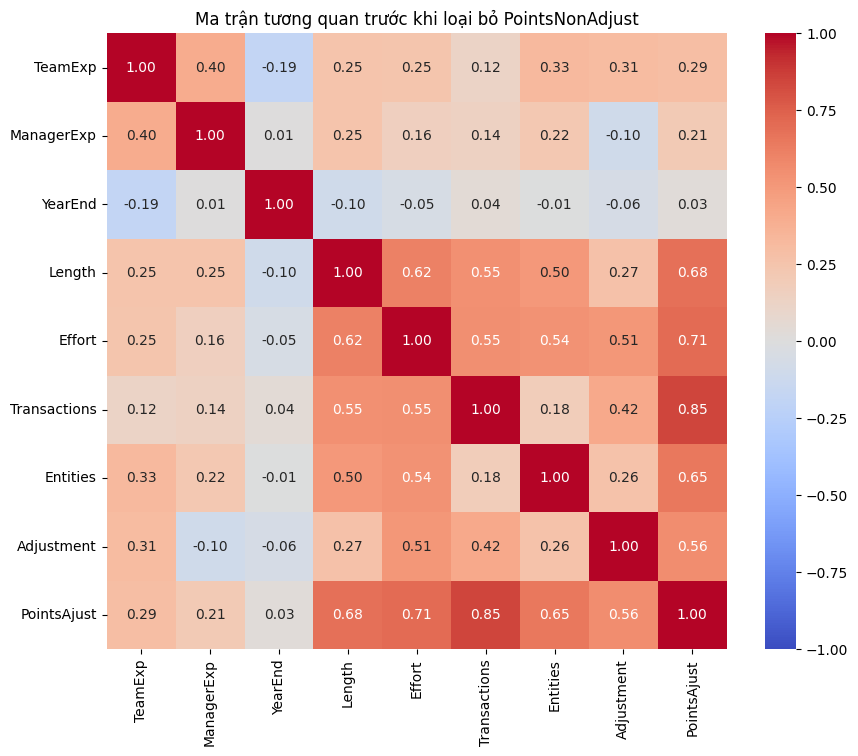

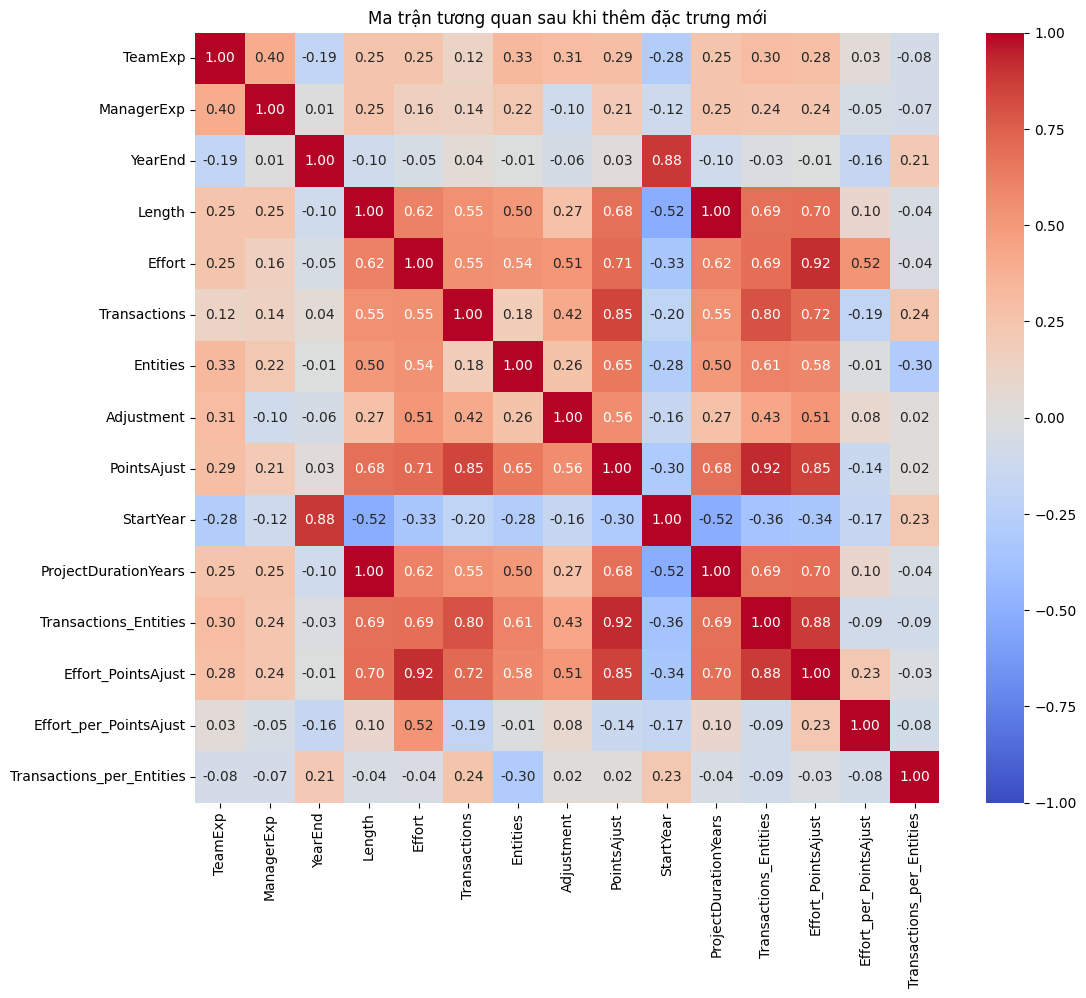


Kiểu dữ liệu sau khi xử lý:
TeamExp                             float64
ManagerExp                          float64
YearEnd                             float64
Length                              float64
Effort                              float64
Transactions                        float64
Entities                            float64
Adjustment                          float64
PointsAjust                         float64
Language_b'1'                         int64
Language_b'2'                         int64
Language_b'3'                         int64
StartTime                    datetime64[ns]
StartYear                           float64
ProjectDurationYears                float64
Transactions_Entities               float64
Effort_PointsAjust                  float64
Effort_per_PointsAjust              float64
Transactions_per_Entities           float64
HighEffort                            int64
HighPointsAjust                       int64
dtype: object

Thống kê sau khi tiêu chuẩn hóa:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Đọc file CSV
df = pd.read_csv('desharnais1.1.csv')

# 1. Thay giá trị âm trong TeamExp và ManagerExp bằng giá trị trung bình
team_exp_mean = df[df['TeamExp'] >= 0]['TeamExp'].mean()
manager_exp_mean = df[df['ManagerExp'] >= 0]['ManagerExp'].mean()
df['TeamExp'] = df['TeamExp'].apply(lambda x: team_exp_mean if x < 0 else x)
df['ManagerExp'] = df['ManagerExp'].apply(lambda x: manager_exp_mean if x < 0 else x)

# 2. Chuyển đổi cột Language sang One-Hot Encoding
df = pd.get_dummies(df, columns=['Language'], prefix='Language')

# Chỉ ép kiểu các cột Language sang int
df['Language_b\'1\''] = df['Language_b\'1\''].astype(int)
df['Language_b\'2\''] = df['Language_b\'2\''].astype(int)
df['Language_b\'3\''] = df['Language_b\'3\''].astype(int)

# 3. Tạo cột TimeIndex
df['TimeIndex'] = pd.to_datetime(df['YearEnd'].astype(int).astype(str) + '-12-31')

# 4. Tạo cột StartTime
df['StartTime'] = df.apply(
    lambda row: pd.to_datetime(str(int(row['YearEnd']) - int(row['Length'] / 12)) + '-01-01'), axis=1
)

# 5. Sắp xếp theo TimeIndex
df = df.sort_values(by='TimeIndex')

# 6. Đặt TimeIndex làm chỉ số
df = df.set_index('TimeIndex')

# 7. Xử lý giá trị thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())

# Thay giá trị 0 không hợp lý bằng trung bình
numeric_columns = ['Effort', 'Transactions', 'Entities', 'PointsAjust']
for col in numeric_columns:
    if (df[col] == 0).sum() > 0:
        df[col] = df[col].replace(0, df[col].mean())

# 8. Xử lý ngoại lai
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

for col in ['Effort', 'Transactions', 'Entities', 'PointsAjust']:
    df = cap_outliers(df, col)

# 9. Trực quan hóa dữ liệu để phân tích tương quan
correlation_matrix = df[['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 
                        'Transactions', 'Entities', 'Adjustment', 'PointsAjust']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Ma trận tương quan trước khi loại bỏ PointsNonAdjust')
plt.show()

# 10. Xử lý đa cộng tuyến: Loại bỏ PointsNonAdjust và Project
df = df.drop(['PointsNonAdjust', 'Project'], axis=1)

# Cập nhật danh sách cột số
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust']

# 11. Tạo các đặc trưng mới
# Từ cột thời gian
df['StartYear'] = df['StartTime'].dt.year
df['ProjectDurationYears'] = df['Length'] / 12.0

# Tương tác giữa các biến
df['Transactions_Entities'] = df['Transactions'] * df['Entities']
df['Effort_PointsAjust'] = df['Effort'] * df['PointsAjust']

# Tỷ lệ
df['Effort_per_PointsAjust'] = df['Effort'] / df['PointsAjust'].replace(0, 1e-6)  # Tránh chia cho 0
df['Transactions_per_Entities'] = df['Transactions'] / df['Entities'].replace(0, 1e-6)  # Tránh chia cho 0

# Phân loại dựa trên ngưỡng
effort_mean = df['Effort'].mean()
points_adjust_mean = df['PointsAjust'].mean()
df['HighEffort'] = (df['Effort'] > effort_mean).astype(int)
df['HighPointsAjust'] = (df['PointsAjust'] > points_adjust_mean).astype(int)

# 12. Tiêu chuẩn hóa dữ liệu
scaler = StandardScaler()
# Cập nhật danh sách cột số với các cột mới
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# 13. Kiểm tra lại ma trận tương quan với các cột mới
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Ma trận tương quan sau khi thêm đặc trưng mới')
plt.show()

# 14. Kiểm tra kết quả
print("\nKiểu dữ liệu sau khi xử lý:")
print(df.dtypes)
print("\nThống kê sau khi tiêu chuẩn hóa:")
print(df[numeric_columns].describe())
print("\nDữ liệu mẫu:")
print(df[['YearEnd', 'Length', 'StartTime', 'Effort', 'Transactions', 'Entities', 
          'PointsAjust', 'StartYear', 'ProjectDurationYears', 'HighEffort']].head())

# 15. Lưu dữ liệu đã xử lý
df['StartTime'] = df['StartTime'].astype(str)  # Chuyển StartTime thành chuỗi để lưu CSV
df.to_csv('desharnais1.1_processed_corrected.csv')

# CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Đọc dữ liệu đã tiền xử lý
df = pd.read_csv('desharnais1.1_processed_corrected.csv')


# Danh sách các cột số và nhị phân
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']

# Chuyển đổi các cột số sang float
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Chuyển đổi các cột nhị phân sang int
for col in binary_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('int')

# Kiểm tra giá trị NaN
print("\nSố lượng giá trị NaN trong mỗi cột:")
print(df.isnull().sum())

# Thay thế NaN bằng giá trị trung bình cho các cột số
for col in numeric_columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

# Kiểm tra lại kiểu dữ liệu
print("\nKiểu dữ liệu sau khi chuyển đổi:")
print(df.dtypes)

# Chọn đặc trưng và biến mục tiêu
features = numeric_columns + binary_columns
X = df[features].values
y = df['Effort'].values

# Kiểm tra kiểu dữ liệu của X
print("\nKiểu dữ liệu của X:", X.dtype)
if not np.issubdtype(X.dtype, np.number):
    print("Các cột không phải số trong features:", [col for col in features if not np.issubdtype(df[col].dtype, np.number)])
    raise ValueError("X contains non-numeric values. Please check the data types.")

# Kiểm tra NaN trong X
if np.any(np.isnan(X)):
    raise ValueError("X contains NaN values. Please check the data.")

# Tăng cường dữ liệu bằng nhiễu Gaussian
def add_gaussian_noise(X, noise_factor=0.01):
    if not np.issubdtype(X.dtype, np.number):
        raise ValueError("Input X must be numeric.")
    if np.any(np.isnan(X)):
        raise ValueError("Input X contains NaN values.")
    noise = np.random.normal(loc=0, scale=noise_factor, size=X.shape)
    return X + noise

X_augmented = X.copy()
y_augmented = y.copy()
for _ in range(2):  # Tạo thêm 2 bản sao với nhiễu
    X_noisy = add_gaussian_noise(X, noise_factor=0.01)
    X_augmented = np.vstack((X_augmented, X_noisy))
    y_augmented = np.hstack((y_augmented, y))

print("\n=== Sau khi tăng cường dữ liệu bằng nhiễu Gaussian ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Reshape dữ liệu cho Conv1D
X_augmented = X_augmented.reshape(X_augmented.shape[0], X_augmented.shape[1], 1)

print("\n=== Kích thước dữ liệu sau reshape ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu CNN:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình CNN với Flatten
def build_cnn_model(filters=8, l2_reg=0.01, dense_units=16, dropout_rate=0.3, learning_rate=0.001):
    l2_reg = max(l2_reg, 0.001)
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters, kernel_size=2, activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv1D(filters, kernel_size=2, activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'filters': (4, 16),
    'l2_reg': (0.001, 0.05),
    'dense_units': (8, 32),
    'dropout_rate': (0.2, 0.4),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['filters'][0], param_bounds['filters'][1] + 1),
        np.random.uniform(param_bounds['l2_reg'][0], param_bounds['l2_reg'][1]),
        np.random.randint(param_bounds['dense_units'][0], param_bounds['dense_units'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'filters': int(particle[0]),
        'l2_reg': particle[1],
        'dense_units': int(particle[2]),
        'dropout_rate': particle[3],
        'learning_rate': particle[4],
        'batch_size': int(particle[5]),
        'epochs': int(particle[6])
    }
    params['l2_reg'] = max(params['l2_reg'], 0.001)
    params['l2_reg'] = min(params['l2_reg'], param_bounds['l2_reg'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_cnn_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_cnn(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][1] = max(particles[i][1], param_bounds['l2_reg'][0])
            particles[i][1] = min(particles[i][1], param_bounds['l2_reg'][1])
            particles[i][3] = np.clip(particles[i][3], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_cnn(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_cnn_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('cnn_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'cnn_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('cnn_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'cnn_visualization_results_scaled.png'")

model_optimal.save('rbfn_model.keras')
print("\nĐã lưu mô hình vào 'rbfn_model.keras'")

FileNotFoundError: [Errno 2] No such file or directory: 'desharnais1.1_processed_corrected.csv'

# MLP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Transformer tùy chỉnh để chuyển đổi kiểu dữ liệu
class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, binary_cols):
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        for col in self.binary_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype('int')
        return X_copy

# Transformer tùy chỉnh để xử lý NaN
class NaNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.means_ = {}
    
    def fit(self, X, y=None):
        for col in self.numeric_cols:
            self.means_[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col].fillna(self.means_[col], inplace=True)
        return X_copy

# Transformer tùy chỉnh để tiêu chuẩn hóa (chỉ các cột số)
class SelectiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.scaler_ = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.numeric_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler_.transform(X_copy[self.numeric_cols])
        return X_copy

# Transformer tùy chỉnh để tăng cường dữ liệu
class DataAugmenter(BaseEstimator, TransformerMixin):
    def __init__(self, noise_factor=0.01, n_copies=2):
        self.noise_factor = noise_factor
        self.n_copies = n_copies
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_augmented = X.copy()
        y_augmented = y.copy() if y is not None else None
        for _ in range(self.n_copies):
            noise = np.random.normal(loc=0, scale=self.noise_factor, size=X.shape)
            X_noisy = X + noise
            X_augmented = np.vstack((X_augmented, X_noisy))
            if y is not None:
                y_augmented = np.hstack((y_augmented, y))
        return X_augmented, y_augmented

# Đọc dữ liệu
df = pd.read_csv('desharnais1.1_processed_corrected.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Kiểu dữ liệu:")
print(df.dtypes)
print("Mẫu 5 hàng đầu tiên:")
print(df.head())

# Định nghĩa các cột
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']
features = numeric_columns + binary_columns
target = 'Effort'

# Tạo pipeline
pipeline = Pipeline([
    ('data_type_converter', DataTypeConverter(numeric_cols=numeric_columns, binary_cols=binary_columns)),
    ('nan_imputer', NaNImputer(numeric_cols=numeric_columns)),
    ('scaler', SelectiveScaler(numeric_cols=numeric_columns)),
])

# Chuẩn bị dữ liệu
X = df[features]
y = df[target].values

# Áp dụng pipeline
X_transformed = pipeline.fit_transform(X)

# Tăng cường dữ liệu
data_augmenter = DataAugmenter(noise_factor=0.01, n_copies=2)
X_augmented, y_augmented = data_augmenter.transform(X_transformed.values, y)

print("\n=== Sau khi tăng cường dữ liệu ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu MLP:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình MLP
def build_mlp_model(dense_units_1=64, dense_units_2=32, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(dense_units_1, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'dense_units_1': (32, 128),
    'dense_units_2': (16, 64),
    'dropout_rate': (0.2, 0.4),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['dense_units_1'][0], param_bounds['dense_units_1'][1] + 1),
        np.random.randint(param_bounds['dense_units_2'][0], param_bounds['dense_units_2'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'dense_units_1': int(particle[0]),
        'dense_units_2': int(particle[1]),
        'dropout_rate': particle[2],
        'learning_rate': particle[3],
        'batch_size': int(particle[4]),
        'epochs': int(particle[5])
    }
    params['dropout_rate'] = np.clip(params['dropout_rate'], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_mlp_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_mlp(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][2] = np.clip(particles[i][2], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_mlp(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_mlp_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('mlp_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'mlp_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('mlp_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'mlp_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (81, 22)
Các cột: ['TimeIndex', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'Adjustment', 'PointsAjust', "Language_b'1'", "Language_b'2'", "Language_b'3'", 'StartTime', 'StartYear', 'ProjectDurationYears', 'Transactions_Entities', 'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities', 'HighEffort', 'HighPointsAjust']
Kiểu dữ liệu:
TimeIndex                     object
TeamExp                      float64
ManagerExp                   float64
YearEnd                      float64
Length                       float64
Effort                       float64
Transactions                 float64
Entities                     float64
Adjustment                   float64
PointsAjust                  float64
Language_b'1'                  int64
Language_b'2'                  int64
Language_b'3'                  int64
StartTime                     object
StartYear                    float64
ProjectDurati

C:\Users\lequa\AppData\Local\Temp\ipykernel_24700\1730041727.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(self.means_[col], inplace=True)



🔁 Iteration 1/10
✅ Cập nhật g_best: Score = 0.0921
✅ Cập nhật g_best: Score = 0.0889

🔁 Iteration 2/10
✅ Cập nhật g_best: Score = 0.0857
✅ Cập nhật g_best: Score = 0.0679

🔁 Iteration 3/10
✅ Cập nhật g_best: Score = 0.0643
✅ Cập nhật g_best: Score = 0.0635

🔁 Iteration 4/10
✅ Cập nhật g_best: Score = 0.0631

🔁 Iteration 5/10
✅ Cập nhật g_best: Score = 0.0588

🔁 Iteration 6/10

🔁 Iteration 7/10

🔁 Iteration 8/10

🔁 Iteration 9/10

🔁 Iteration 10/10
✅ Cập nhật g_best: Score = 0.0582
🏆 Siêu tham số tốt nhất: {'dense_units_1': 128, 'dense_units_2': 64, 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.01), 'batch_size': 16, 'epochs': 100}
📉 Score tốt nhất: 0.0582

📂 Fold 1/3
✅ Fold 1 RMSE: 0.0825

📂 Fold 2/3
✅ Fold 2 RMSE: 0.0744

📂 Fold 3/3
✅ Fold 3 RMSE: 0.0670

📊 RMSE trung bình qua 3 folds: 0.0746

📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):
📌 MSE     : 0.0091 ± 0.0019
📌 RMSE    : 0.0949 ± 0.0098
📌 MAE     : 0.0792 ± 0.0087
📌 R²      : 0.9934 ± 0.0012
📌 MAPE    

# LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Transformer tùy chỉnh để chuyển đổi kiểu dữ liệu
class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, binary_cols):
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        for col in self.binary_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype('int')
        return X_copy

# Transformer tùy chỉnh để xử lý NaN
class NaNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.means_ = {}
    
    def fit(self, X, y=None):
        for col in self.numeric_cols:
            self.means_[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col].fillna(self.means_[col], inplace=True)
        return X_copy

# Transformer tùy chỉnh để tiêu chuẩn hóa (chỉ các cột số)
class SelectiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.scaler_ = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.numeric_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler_.transform(X_copy[self.numeric_cols])
        return X_copy

# Transformer tùy chỉnh để tăng cường dữ liệu và reshape cho LSTM
class DataAugmenterLSTM(BaseEstimator, TransformerMixin):
    def __init__(self, noise_factor=0.01, n_copies=2, timesteps=1):
        self.noise_factor = noise_factor
        self.n_copies = n_copies
        self.timesteps = timesteps
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_augmented = X.copy()
        y_augmented = y.copy() if y is not None else None
        for _ in range(self.n_copies):
            noise = np.random.normal(loc=0, scale=self.noise_factor, size=X.shape)
            X_noisy = X + noise
            X_augmented = np.vstack((X_augmented, X_noisy))
            if y is not None:
                y_augmented = np.hstack((y_augmented, y))
        # Reshape cho LSTM: (samples, timesteps, features)
        X_augmented = X_augmented.reshape(X_augmented.shape[0], self.timesteps, X_augmented.shape[1])
        return X_augmented, y_augmented

# Đọc dữ liệu
df = pd.read_csv('desharnais1.1_processed_corrected.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Kiểu dữ liệu:")
print(df.dtypes)
print("Mẫu 5 hàng đầu tiên:")
print(df.head())

# Định nghĩa các cột
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']
features = numeric_columns + binary_columns
target = 'Effort'

# Tạo pipeline
pipeline = Pipeline([
    ('data_type_converter', DataTypeConverter(numeric_cols=numeric_columns, binary_cols=binary_columns)),
    ('nan_imputer', NaNImputer(numeric_cols=numeric_columns)),
    ('scaler', SelectiveScaler(numeric_cols=numeric_columns)),
])

# Chuẩn bị dữ liệu
X = df[features]
y = df[target].values

# Áp dụng pipeline
X_transformed = pipeline.fit_transform(X)

# Tăng cường dữ liệu và reshape cho LSTM
data_augmenter = DataAugmenterLSTM(noise_factor=0.01, n_copies=2, timesteps=1)
X_augmented, y_augmented = data_augmenter.transform(X_transformed.values, y)

print("\n=== Sau khi tăng cường dữ liệu ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu LSTM:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình LSTM
def build_lstm_model(lstm_units=32, dense_units=16, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'lstm_units': (16, 64),
    'dense_units': (8, 32),
    'dropout_rate': (0.2, 0.4),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['lstm_units'][0], param_bounds['lstm_units'][1] + 1),
        np.random.randint(param_bounds['dense_units'][0], param_bounds['dense_units'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'lstm_units': int(particle[0]),
        'dense_units': int(particle[1]),
        'dropout_rate': particle[2],
        'learning_rate': particle[3],
        'batch_size': int(particle[4]),
        'epochs': int(particle[5])
    }
    params['dropout_rate'] = np.clip(params['dropout_rate'], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_lstm_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_lstm(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][2] = np.clip(particles[i][2], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_lstm(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_lstm_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.nanmean(bootstrap_metrics['mape']):.2f}% ± {np.nanstd(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.nanmean(bootstrap_metrics['mmre']):.4f} ± {np.nanstd(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.nanmean(bootstrap_metrics['mdmre']):.4f} ± {np.nanstd(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.nanmean(bootstrap_metrics['pred25']):.2f}% ± {np.nanstd(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.nanmean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.nanstd(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.nanmean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.nanstd(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.nanmean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.nanstd(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.nanmean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.nanstd(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('lstm_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'lstm_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('lstm_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'lstm_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (81, 22)
Các cột: ['TimeIndex', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'Adjustment', 'PointsAjust', "Language_b'1'", "Language_b'2'", "Language_b'3'", 'StartTime', 'StartYear', 'ProjectDurationYears', 'Transactions_Entities', 'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities', 'HighEffort', 'HighPointsAjust']
Kiểu dữ liệu:
TimeIndex                     object
TeamExp                      float64
ManagerExp                   float64
YearEnd                      float64
Length                       float64
Effort                       float64
Transactions                 float64
Entities                     float64
Adjustment                   float64
PointsAjust                  float64
Language_b'1'                  int64
Language_b'2'                  int64
Language_b'3'                  int64
StartTime                     object
StartYear                    float64
ProjectDurati

C:\Users\lequa\AppData\Local\Temp\ipykernel_24700\1767490533.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(self.means_[col], inplace=True)



🔁 Iteration 1/10
✅ Cập nhật g_best: Score = 0.0927
✅ Cập nhật g_best: Score = 0.0749

🔁 Iteration 2/10
✅ Cập nhật g_best: Score = 0.0718
✅ Cập nhật g_best: Score = 0.0654
✅ Cập nhật g_best: Score = 0.0632
✅ Cập nhật g_best: Score = 0.0607

🔁 Iteration 3/10
✅ Cập nhật g_best: Score = 0.0585

🔁 Iteration 4/10
✅ Cập nhật g_best: Score = 0.0547

🔁 Iteration 5/10

🔁 Iteration 6/10
✅ Cập nhật g_best: Score = 0.0511

🔁 Iteration 7/10

🔁 Iteration 8/10

🔁 Iteration 9/10

🔁 Iteration 10/10
🏆 Siêu tham số tốt nhất: {'lstm_units': 71, 'dense_units': 32, 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.012384057884992687), 'batch_size': 11, 'epochs': 100}
📉 Score tốt nhất: 0.0511

📂 Fold 1/3
✅ Fold 1 RMSE: 0.0575

📂 Fold 2/3
✅ Fold 2 RMSE: 0.0480

📂 Fold 3/3
✅ Fold 3 RMSE: 0.0398

📊 RMSE trung bình qua 3 folds: 0.0484

📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):
📌 MSE     : 0.0040 ± 0.0009
📌 RMSE    : 0.0624 ± 0.0072
📌 MAE     : 0.0496 ± 0.0067
📌 R²      : 0.9971 ± 0.0007


# RBFN

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Layer

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Lớp RBF tùy chỉnh
class RBFLayer(Layer):
    def __init__(self, n_centers, sigma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.n_centers = n_centers
        self.sigma = sigma
    
    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                      shape=(self.n_centers, input_shape[1]),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.sigma = self.add_weight(name='sigma',
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.sigma),
                                    trainable=True)
        super(RBFLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Tính khoảng cách Euclidean bình phương
        diff = tf.expand_dims(inputs, axis=1) - tf.expand_dims(self.centers, axis=0)
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)
        # Hàm Gaussian
        return tf.exp(-l2 / (2.0 * tf.square(self.sigma)))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_centers)

# Transformer tùy chỉnh để chuyển đổi kiểu dữ liệu
class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, binary_cols):
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        for col in self.binary_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype('int')
        return X_copy

# Transformer tùy chỉnh để xử lý NaN
class NaNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.means_ = {}
    
    def fit(self, X, y=None):
        for col in self.numeric_cols:
            self.means_[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col].fillna(self.means_[col], inplace=True)
        return X_copy

# Transformer tùy chỉnh để tiêu chuẩn hóa (chỉ các cột số)
class SelectiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.scaler_ = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.numeric_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler_.transform(X_copy[self.numeric_cols])
        return X_copy

# Transformer tùy chỉnh để tăng cường dữ liệu
class DataAugmenter(BaseEstimator, TransformerMixin):
    def __init__(self, noise_factor=0.01, n_copies=2):
        self.noise_factor = noise_factor
        self.n_copies = n_copies
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_augmented = X.copy()
        y_augmented = y.copy() if y is not None else None
        for _ in range(self.n_copies):
            noise = np.random.normal(loc=0, scale=self.noise_factor, size=X.shape)
            X_noisy = X + noise
            X_augmented = np.vstack((X_augmented, X_noisy))
            if y is not None:
                y_augmented = np.hstack((y_augmented, y))
        return X_augmented, y_augmented

# Đọc dữ liệu
df = pd.read_csv('desharnais1.1_processed_corrected.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Kiểu dữ liệu:")
print(df.dtypes)
print("Mẫu 5 hàng đầu tiên:")
print(df.head())

# Định nghĩa các cột
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']
features = numeric_columns + binary_columns
target = 'Effort'

# Tạo pipeline
pipeline = Pipeline([
    ('data_type_converter', DataTypeConverter(numeric_cols=numeric_columns, binary_cols=binary_columns)),
    ('nan_imputer', NaNImputer(numeric_cols=numeric_columns)),
    ('scaler', SelectiveScaler(numeric_cols=numeric_columns)),
])

# Chuẩn bị dữ liệu
X = df[features]
y = df[target].values

# Áp dụng pipeline
X_transformed = pipeline.fit_transform(X)

# Tăng cường dữ liệu
data_augmenter = DataAugmenter(noise_factor=0.01, n_copies=2)
X_augmented, y_augmented = data_augmenter.transform(X_transformed.values, y)

print("\n=== Sau khi tăng cường dữ liệu ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu RBFN:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình RBFN
def build_rbfn_model(n_centers=20, sigma=1.0, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        RBFLayer(n_centers, sigma=sigma),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'n_centers': (10, 50),
    'sigma': (0.1, 2.0),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['n_centers'][0], param_bounds['n_centers'][1] + 1),
        np.random.uniform(param_bounds['sigma'][0], param_bounds['sigma'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'n_centers': int(particle[0]),
        'sigma': particle[1],
        'learning_rate': particle[2],
        'batch_size': int(particle[3]),
        'epochs': int(particle[4])
    }
    params['sigma'] = np.clip(params['sigma'], param_bounds['sigma'][0], param_bounds['sigma'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_rbfn_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_rbfn(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][1] = np.clip(particles[i][1], param_bounds['sigma'][0], param_bounds['sigma'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_rbfn(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_rbfn_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.nanmean(bootstrap_metrics['mape']):.2f}% ± {np.nanstd(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.nanmean(bootstrap_metrics['mmre']):.4f} ± {np.nanstd(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.nanmean(bootstrap_metrics['mdmre']):.4f} ± {np.nanstd(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.nanmean(bootstrap_metrics['pred25']):.2f}% ± {np.nanstd(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.nanmean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.nanstd(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.nanmean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.nanstd(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.nanmean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.nanstd(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.nanmean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.nanstd(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('rbfn_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'rbfn_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('rbfn_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'rbfn_visualization_results_scaled.png'")

model_optimal.save('rbfn_model.keras')
print("\nĐã lưu mô hình vào 'rbfn_model.keras'")

=== Kiểm tra dữ liệu ===
Kích thước: (81, 22)
Các cột: ['TimeIndex', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'Adjustment', 'PointsAjust', "Language_b'1'", "Language_b'2'", "Language_b'3'", 'StartTime', 'StartYear', 'ProjectDurationYears', 'Transactions_Entities', 'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities', 'HighEffort', 'HighPointsAjust']
Kiểu dữ liệu:
TimeIndex                     object
TeamExp                      float64
ManagerExp                   float64
YearEnd                      float64
Length                       float64
Effort                       float64
Transactions                 float64
Entities                     float64
Adjustment                   float64
PointsAjust                  float64
Language_b'1'                  int64
Language_b'2'                  int64
Language_b'3'                  int64
StartTime                     object
StartYear                    float64
ProjectDurati

C:\Users\lequa\AppData\Local\Temp\ipykernel_14864\157341998.py:106: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(self.means_[col], inplace=True)



🔁 Iteration 1/10
✅ Cập nhật g_best: Score = 0.1445
✅ Cập nhật g_best: Score = 0.1242

🔁 Iteration 2/10

🔁 Iteration 3/10
✅ Cập nhật g_best: Score = 0.1203

🔁 Iteration 4/10


: 

# RNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Transformer tùy chỉnh để chuyển đổi kiểu dữ liệu
class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, binary_cols):
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        for col in self.binary_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype('int')
        return X_copy

# Transformer tùy chỉnh để xử lý NaN
class NaNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.means_ = {}
    
    def fit(self, X, y=None):
        for col in self.numeric_cols:
            self.means_[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col].fillna(self.means_[col], inplace=True)
        return X_copy

# Transformer tùy chỉnh để tiêu chuẩn hóa (chỉ các cột số)
class SelectiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.scaler_ = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.numeric_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler_.transform(X_copy[self.numeric_cols])
        return X_copy

# Transformer tùy chỉnh để tăng cường dữ liệu và reshape cho RNN
class DataAugmenterRNN(BaseEstimator, TransformerMixin):
    def __init__(self, noise_factor=0.01, n_copies=2, timesteps=1):
        self.noise_factor = noise_factor
        self.n_copies = n_copies
        self.timesteps = timesteps
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_augmented = X.copy()
        y_augmented = y.copy() if y is not None else None
        for _ in range(self.n_copies):
            noise = np.random.normal(loc=0, scale=self.noise_factor, size=X.shape)
            X_noisy = X + noise
            X_augmented = np.vstack((X_augmented, X_noisy))
            if y is not None:
                y_augmented = np.hstack((y_augmented, y))
        # Reshape cho RNN: (samples, timesteps, features)
        X_augmented = X_augmented.reshape(X_augmented.shape[0], self.timesteps, X_augmented.shape[1])
        return X_augmented, y_augmented

# Đọc dữ liệu
df = pd.read_csv('desharnais1.1_processed_corrected.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Kiểu dữ liệu:")
print(df.dtypes)
print("Mẫu 5 hàng đầu tiên:")
print(df.head())

# Định nghĩa các cột
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']
features = numeric_columns + binary_columns
target = 'Effort'

# Tạo pipeline
pipeline = Pipeline([
    ('data_type_converter', DataTypeConverter(numeric_cols=numeric_columns, binary_cols=binary_columns)),
    ('nan_imputer', NaNImputer(numeric_cols=numeric_columns)),
    ('scaler', SelectiveScaler(numeric_cols=numeric_columns)),
])

# Chuẩn bị dữ liệu
X = df[features]
y = df[target].values

# Áp dụng pipeline
X_transformed = pipeline.fit_transform(X)

# Tăng cường dữ liệu và reshape cho RNN
data_augmenter = DataAugmenterRNN(noise_factor=0.01, n_copies=2, timesteps=1)
X_augmented, y_augmented = data_augmenter.transform(X_transformed.values, y)

print("\n=== Sau khi tăng cường dữ liệu ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu RNN:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình RNN
def build_rnn_model(rnn_units=32, dense_units=16, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        SimpleRNN(rnn_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'rnn_units': (16, 64),
    'dense_units': (8, 32),
    'dropout_rate': (0.2, 0.4),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['rnn_units'][0], param_bounds['rnn_units'][1] + 1),
        np.random.randint(param_bounds['dense_units'][0], param_bounds['dense_units'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'rnn_units': int(particle[0]),
        'dense_units': int(particle[1]),
        'dropout_rate': particle[2],
        'learning_rate': particle[3],
        'batch_size': int(particle[4]),
        'epochs': int(particle[5])
    }
    params['dropout_rate'] = np.clip(params['dropout_rate'], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_rnn_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_rnn(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][2] = np.clip(particles[i][2], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_rnn(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_rnn_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.nanmean(bootstrap_metrics['mape']):.2f}% ± {np.nanstd(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.nanmean(bootstrap_metrics['mmre']):.4f} ± {np.nanstd(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.nanmean(bootstrap_metrics['mdmre']):.4f} ± {np.nanstd(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.nanmean(bootstrap_metrics['pred25']):.2f}% ± {np.nanstd(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.nanmean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.nanstd(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.nanmean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.nanstd(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.nanmean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.nanstd(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.nanmean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.nanstd(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('rnn_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'rnn_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('rnn_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'rnn_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (81, 22)
Các cột: ['TimeIndex', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'Adjustment', 'PointsAjust', "Language_b'1'", "Language_b'2'", "Language_b'3'", 'StartTime', 'StartYear', 'ProjectDurationYears', 'Transactions_Entities', 'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities', 'HighEffort', 'HighPointsAjust']
Kiểu dữ liệu:
TimeIndex                     object
TeamExp                      float64
ManagerExp                   float64
YearEnd                      float64
Length                       float64
Effort                       float64
Transactions                 float64
Entities                     float64
Adjustment                   float64
PointsAjust                  float64
Language_b'1'                  int64
Language_b'2'                  int64
Language_b'3'                  int64
StartTime                     object
StartYear                    float64
ProjectDurati

C:\Users\lequa\AppData\Local\Temp\ipykernel_12912\393591149.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(self.means_[col], inplace=True)



🔁 Iteration 1/10
✅ Cập nhật g_best: Score = 0.0996
✅ Cập nhật g_best: Score = 0.0944
✅ Cập nhật g_best: Score = 0.0822

🔁 Iteration 2/10

🔁 Iteration 3/10
✅ Cập nhật g_best: Score = 0.0741
✅ Cập nhật g_best: Score = 0.0683

🔁 Iteration 4/10

🔁 Iteration 5/10

🔁 Iteration 6/10

🔁 Iteration 7/10

🔁 Iteration 8/10

🔁 Iteration 9/10

🔁 Iteration 10/10
🏆 Siêu tham số tốt nhất: {'rnn_units': 72, 'dense_units': 36, 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.011868317981820576), 'batch_size': 14, 'epochs': 41}
📉 Score tốt nhất: 0.0683

📂 Fold 1/3
✅ Fold 1 RMSE: 0.0879

📂 Fold 2/3
✅ Fold 2 RMSE: 0.0900

📂 Fold 3/3
✅ Fold 3 RMSE: 0.0897

📊 RMSE trung bình qua 3 folds: 0.0892

📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):
📌 MSE     : 0.0121 ± 0.0029
📌 RMSE    : 0.1094 ± 0.0132
📌 MAE     : 0.0893 ± 0.0107
📌 R²      : 0.9911 ± 0.0022
📌 MAPE    : 113.34% ± 94.03%
📌 MMRE    : 1.1334 ± 0.9403
📌 MdMRE   : 0.0922 ± 0.0631
📌 PRED(25): 76.16% ± 10.61%

Đã lưu kết quả đánh giá 

# BiLSTM

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Transformer tùy chỉnh để chuyển đổi kiểu dữ liệu
class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, binary_cols):
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        for col in self.binary_cols:
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype('int')
        return X_copy

# Transformer tùy chỉnh để xử lý NaN
class NaNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.means_ = {}
    
    def fit(self, X, y=None):
        for col in self.numeric_cols:
            self.means_[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col].fillna(self.means_[col], inplace=True)
        return X_copy

# Transformer tùy chỉnh để tiêu chuẩn hóa (chỉ các cột số)
class SelectiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.scaler_ = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.numeric_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler_.transform(X_copy[self.numeric_cols])
        return X_copy

# Transformer tùy chỉnh để tăng cường dữ liệu và reshape cho BiLSTM
class DataAugmenterBiLSTM(BaseEstimator, TransformerMixin):
    def __init__(self, noise_factor=0.01, n_copies=2, timesteps=1):
        self.noise_factor = noise_factor
        self.n_copies = n_copies
        self.timesteps = timesteps
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_augmented = X.copy()
        y_augmented = y.copy() if y is not None else None
        for _ in range(self.n_copies):
            noise = np.random.normal(loc=0, scale=self.noise_factor, size=X.shape)
            X_noisy = X + noise
            X_augmented = np.vstack((X_augmented, X_noisy))
            if y is not None:
                y_augmented = np.hstack((y_augmented, y))
        # Reshape cho BiLSTM: (samples, timesteps, features)
        X_augmented = X_augmented.reshape(X_augmented.shape[0], self.timesteps, X_augmented.shape[1])
        return X_augmented, y_augmented

# Đọc dữ liệu
df = pd.read_csv('desharnais1.1_processed_corrected.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Kiểu dữ liệu:")
print(df.dtypes)
print("Mẫu 5 hàng đầu tiên:")
print(df.head())

# Định nghĩa các cột
numeric_columns = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 
                   'Transactions', 'Entities', 'Adjustment', 'PointsAjust',
                   'StartYear', 'ProjectDurationYears', 'Transactions_Entities',
                   'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities']
binary_columns = ['Language_b\'1\'', 'Language_b\'2\'', 'Language_b\'3\'', 'HighEffort', 'HighPointsAjust']
features = numeric_columns + binary_columns
target = 'Effort'

# Tạo pipeline
pipeline = Pipeline([
    ('data_type_converter', DataTypeConverter(numeric_cols=numeric_columns, binary_cols=binary_columns)),
    ('nan_imputer', NaNImputer(numeric_cols=numeric_columns)),
    ('scaler', SelectiveScaler(numeric_cols=numeric_columns)),
])

# Chuẩn bị dữ liệu
X = df[features]
y = df[target].values

# Áp dụng pipeline
X_transformed = pipeline.fit_transform(X)

# Tăng cường dữ liệu và reshape cho BiLSTM
data_augmenter = DataAugmenterBiLSTM(noise_factor=0.01, n_copies=2, timesteps=1)
X_augmented, y_augmented = data_augmenter.transform(X_transformed.values, y)

print("\n=== Sau khi tăng cường dữ liệu ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu BiLSTM:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình BiLSTM
def build_bilstm_model(lstm_units=32, dense_units=16, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số (điều chỉnh cho BiLSTM)
param_bounds = {
    'lstm_units': (16, 64),  # Thay rnn_units thành lstm_units
    'dense_units': (8, 32),
    'dropout_rate': (0.2, 0.4),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 32),
    'epochs': (50, 100)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['lstm_units'][0], param_bounds['lstm_units'][1] + 1),
        np.random.randint(param_bounds['dense_units'][0], param_bounds['dense_units'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'lstm_units': int(particle[0]),
        'dense_units': int(particle[1]),
        'dropout_rate': particle[2],
        'learning_rate': particle[3],
        'batch_size': int(particle[4]),
        'epochs': int(particle[5])
    }
    params['dropout_rate'] = np.clip(params['dropout_rate'], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_bilstm_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_bilstm(num_particles=15, max_iter=10):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            particles[i][2] = np.clip(particles[i][2], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu cho BiLSTM...")
best_particle, best_score = run_pso_bilstm(num_particles=15, max_iter=10)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_bilstm_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores_optimal = []
history_all = {'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/3")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")
    
    # Lưu lịch sử huấn luyện
    history_all['loss'].append(history.history['loss'])
    history_all['val_loss'].append(history.history['val_loss'])

print(f"\n📊 RMSE trung bình qua 3 folds: {np.mean(rmse_scores_optimal):.4f}")

# Tính trung bình lịch sử huấn luyện
max_len = max(len(h) for h in history_all['loss'])
loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['loss']], axis=0)
val_loss_avg = np.mean([np.pad(h, (0, max_len - len(h)), 'constant', constant_values=np.nan) for h in history_all['val_loss']], axis=0)

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.nanmean(bootstrap_metrics['mape']):.2f}% ± {np.nanstd(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.nanmean(bootstrap_metrics['mmre']):.4f} ± {np.nanstd(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.nanmean(bootstrap_metrics['mdmre']):.4f} ± {np.nanstd(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.nanmean(bootstrap_metrics['pred25']):.2f}% ± {np.nanstd(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.nanmean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.nanstd(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.nanmean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.nanstd(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.nanmean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.nanstd(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.nanmean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.nanstd(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('bilstm_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'bilstm_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss trung bình qua các folds
plt.subplot(2, 2, 1)
plt.plot(loss_avg, label='Training Loss')
plt.plot(val_loss_avg, label='Validation Loss')
plt.title('Average Training and Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test , y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled, BiLSTM)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution (BiLSTM)')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled, BiLSTM)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('bilstm_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'bilstm_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (81, 22)
Các cột: ['TimeIndex', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'Adjustment', 'PointsAjust', "Language_b'1'", "Language_b'2'", "Language_b'3'", 'StartTime', 'StartYear', 'ProjectDurationYears', 'Transactions_Entities', 'Effort_PointsAjust', 'Effort_per_PointsAjust', 'Transactions_per_Entities', 'HighEffort', 'HighPointsAjust']
Kiểu dữ liệu:
TimeIndex                     object
TeamExp                      float64
ManagerExp                   float64
YearEnd                      float64
Length                       float64
Effort                       float64
Transactions                 float64
Entities                     float64
Adjustment                   float64
PointsAjust                  float64
Language_b'1'                  int64
Language_b'2'                  int64
Language_b'3'                  int64
StartTime                     object
StartYear                    float64
ProjectDurati

C:\Users\lequa\AppData\Local\Temp\ipykernel_2300\3883849665.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(self.means_[col], inplace=True)



🔁 Iteration 1/10
✅ Cập nhật g_best: Score = 0.0698
✅ Cập nhật g_best: Score = 0.0592

🔁 Iteration 2/10
✅ Cập nhật g_best: Score = 0.0588

🔁 Iteration 3/10

🔁 Iteration 4/10

🔁 Iteration 5/10

🔁 Iteration 6/10

🔁 Iteration 7/10

🔁 Iteration 8/10

🔁 Iteration 9/10

🔁 Iteration 10/10
🏆 Siêu tham số tốt nhất: {'lstm_units': 63, 'dense_units': 32, 'dropout_rate': np.float64(0.271042994285265), 'learning_rate': np.float64(0.011881781242647178), 'batch_size': 27, 'epochs': 75}
📉 Score tốt nhất: 0.0588

📂 Fold 1/3
✅ Fold 1 RMSE: 0.1088

📂 Fold 2/3
✅ Fold 2 RMSE: 0.1082

📂 Fold 3/3
✅ Fold 3 RMSE: 0.0975

📊 RMSE trung bình qua 3 folds: 0.1048

📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):
📌 MSE     : 0.0096 ± 0.0024
📌 RMSE    : 0.0970 ± 0.0125
📌 MAE     : 0.0734 ± 0.0108
📌 R²      : 0.9929 ± 0.0022
📌 MAPE    : 30.22% ± 21.08%
📌 MMRE    : 0.3022 ± 0.2108
📌 MdMRE   : 0.0548 ± 0.0285
📌 PRED(25): 88.12% ± 7.85%

Đã lưu kết quả đánh giá vào 'bilstm_evaluation_results_scaled.csv'

Đã lưu hình

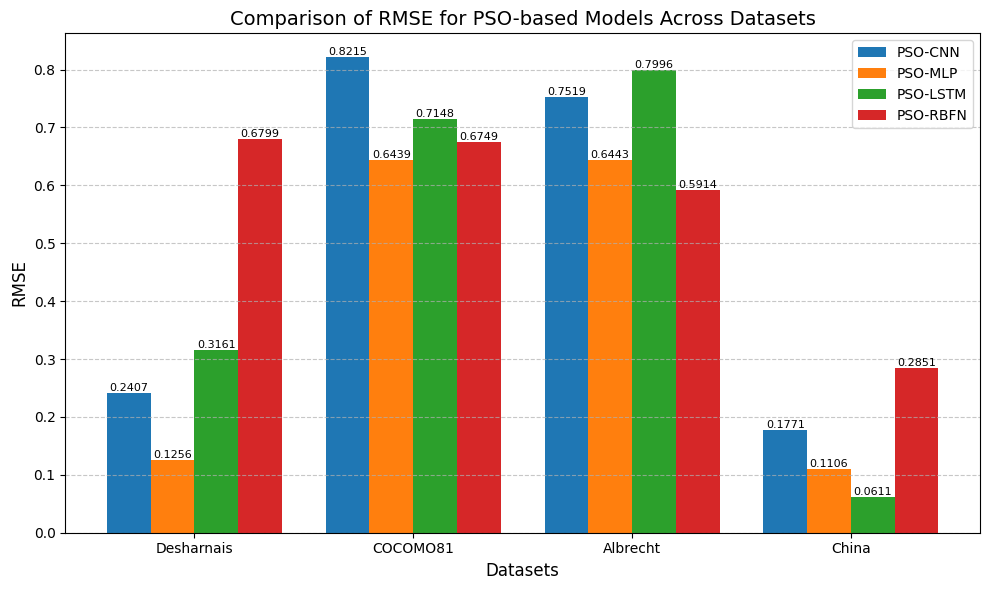

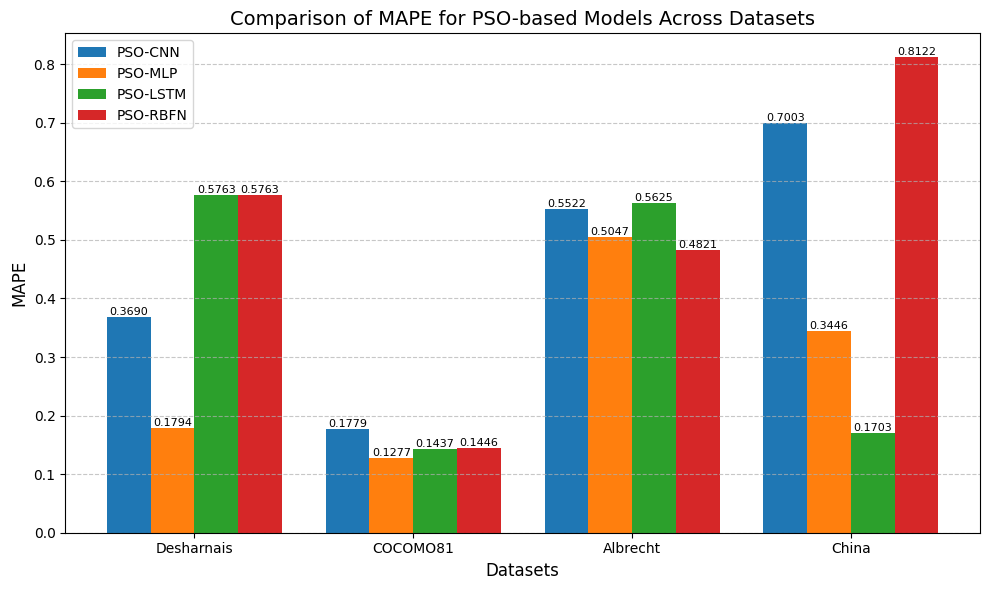

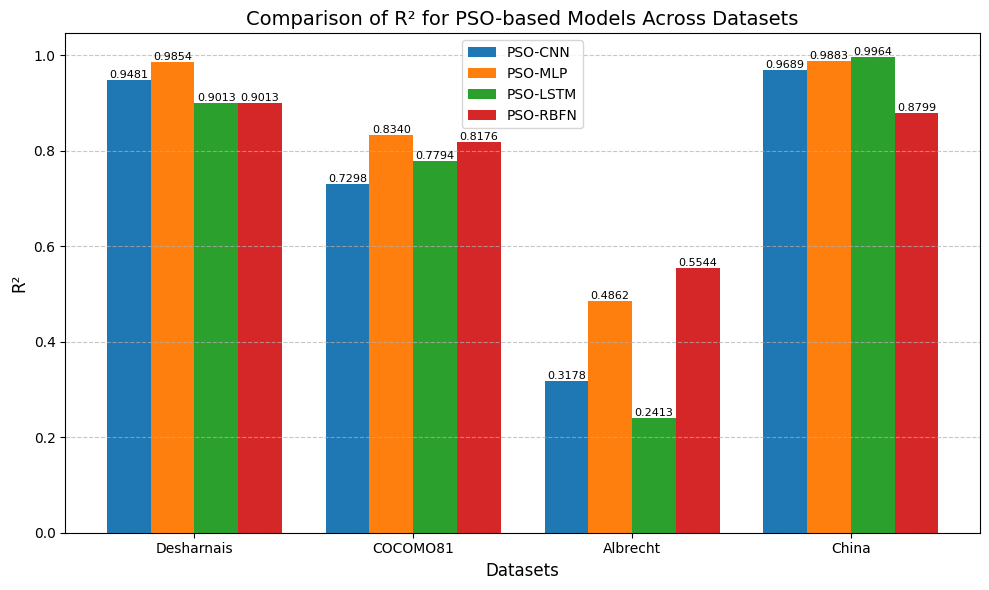

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu
datasets = ['Desharnais', 'COCOMO81', 'Albrecht', 'China']
models = ['PSO-CNN', 'PSO-MLP', 'PSO-LSTM', 'PSO-RBFN']

# Dữ liệu RMSE
rmse_data = {
    'PSO-CNN':  [0.2407, 0.8215, 0.7519, 0.1771],
    'PSO-MLP':  [0.1256, 0.6439, 0.6443, 0.1106],
    'PSO-LSTM': [0.3161, 0.7148, 0.7996, 0.0611],
    'PSO-RBFN': [0.6799, 0.6749, 0.5914, 0.2851]
}

# Dữ liệu MAPE (chuyển từ % sang số thập phân)
mape_data = {
    'PSO-CNN':  [36.90/100, 17.79/100, 55.22/100, 70.03/100],
    'PSO-MLP':  [17.94/100, 12.77/100, 50.47/100, 34.46/100],
    'PSO-LSTM': [57.63/100, 14.37/100, 56.25/100, 17.03/100],
    'PSO-RBFN': [57.63/100, 14.46/100, 48.21/100, 81.22/100]
}

# Dữ liệu R²
r2_data = {
    'PSO-CNN':  [0.9481, 0.7298, 0.3178, 0.9689],
    'PSO-MLP':  [0.9854, 0.8340, 0.4862, 0.9883],
    'PSO-LSTM': [0.9013, 0.7794, 0.2413, 0.9964],
    'PSO-RBFN': [0.9013, 0.8176, 0.5544, 0.8799]
}

# Tạo DataFrame
df_rmse = pd.DataFrame(rmse_data, index=datasets)
df_mape = pd.DataFrame(mape_data, index=datasets)
df_r2 = pd.DataFrame(r2_data, index=datasets)

# Hàm vẽ biểu đồ cột nhóm
def plot_grouped_bar(metric_data, metric_name, ylabel, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(datasets))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Vẽ từng mô hình
    for i, model in enumerate(models):
        bars = ax.bar(index + i*bar_width, metric_data[model], bar_width, label=model, color=colors[i])
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', 
                    ha='center', va='bottom', fontsize=8)

    # Thiết lập biểu đồ
    ax.set_xlabel('Datasets', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f'Comparison of {metric_name} for PSO-based Models Across Datasets', fontsize=14)
    ax.set_xticks(index + bar_width * 1.5)
    ax.set_xticklabels(datasets, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Vẽ biểu đồ cho RMSE
plot_grouped_bar(df_rmse, 'RMSE', 'RMSE', 'rmse_comparison.png')

# Vẽ biểu đồ cho MAPE
plot_grouped_bar(df_mape, 'MAPE', 'MAPE', 'mape_comparison.png')

# Vẽ biểu đồ cho R²
plot_grouped_bar(df_r2, 'R²', 'R²', 'r2_comparison.png')